# Импорты

Импорт всех необходимых библиотек

In [74]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [76]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [77]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

In [78]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [79]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

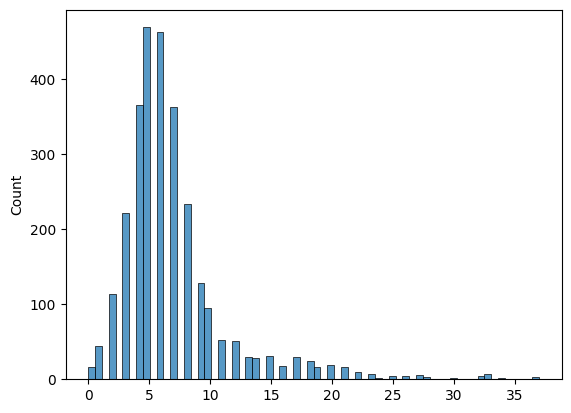

In [80]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

In [81]:
#for i in df.columns:
#  plt.figure()
#  sns.histplot(df[i])

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [82]:
df = df.drop(df[df['bmi']>80].index)

In [83]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

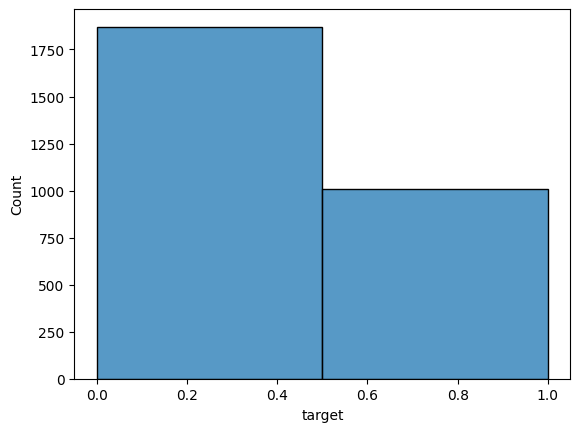

In [84]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [85]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

In [86]:
column_names = df.columns

Поделим датасет на тренировочную, валидационную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

In [87]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df))
df.columns = column_names

In [88]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])

In [89]:
df_temp = df.drop(df_test.index)
x_temp = df_temp.drop(columns=['target'])
y_temp = df_temp['target']
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.15, random_state=42)
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [90]:
x_train = x_train.drop(columns=['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_cr', 'цинк_zn',
        'профессия_работники_преимущественно_умственного_труда',
        'профессия_работники_занятые_легким_физическим_трудом',
        'спорт_легкий_спорт', 'спорт_не_занимаюсь'])
x_val = x_val.drop(columns=['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_cr', 'цинк_zn',
        'профессия_работники_преимущественно_умственного_труда',
        'профессия_работники_занятые_легким_физическим_трудом',
        'спорт_легкий_спорт', 'спорт_не_занимаюсь'])

In [91]:
x_test = x_test.drop(columns=['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_cr', 'цинк_zn',
        'профессия_работники_преимущественно_умственного_труда',
        'профессия_работники_занятые_легким_физическим_трудом',
        'спорт_легкий_спорт', 'спорт_не_занимаюсь'])

In [92]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_val = pd.DataFrame(scaler.transform(x_val))
x_test = pd.DataFrame(scaler.transform(x_test))

In [93]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость'}

In [94]:
x_train = x_train.rename(columns=column_dict)
x_val = x_val.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость
0,-0.663953
1,1.182088
2,0.774257
3,-0.053883
4,0.166443
...,...
2077,-0.188327
2078,-0.763242
2079,-1.165636
2080,-0.019465


Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. RandomForest

In [95]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [96]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-18 17:23:26,151] A new study created in memory with name: no-name-713fbd47-c822-4c9c-acb4-cf6c3da6cb6c
[I 2024-11-18 17:23:27,073] Trial 0 finished with value: 0.3642611683848797 and parameters: {'max_depth': 9, 'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.3642611683848797.
[I 2024-11-18 17:23:27,507] Trial 1 finished with value: 0.3649122807017544 and parameters: {'max_depth': 5, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.3649122807017544.
[I 2024-11-18 17:23:28,504] Trial 2 finished with value: 0.4459016393442623 and parameters: {'max_depth': 4, 'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.4459016393442623.
[I 2024-11-18 17:23:29,903] Trial 3 finished with value: 0.3673469387755102 and parameters: {'max_depth': 7, 'n_estimators': 600, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with value: 0

In [97]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 4}
Best ROC-AUC score: 0.5093167701863354


In [98]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=3, min_samples_leaf=4,
                       min_samples_split=8, n_estimators=200)

Метрики, получаемые из кросс-валидации

In [99]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.31988525, 0.32210922, 0.3276701 , 0.31882906, 0.31925058]),
 'score_time': array([0.04253697, 0.04305863, 0.04265928, 0.04134607, 0.04332113]),
 'test_accuracy': array([0.81055156, 0.81534772, 0.81971154, 0.81009615, 0.79567308]),
 'test_precision_macro': array([0.78417266, 0.79011032, 0.79623678, 0.78310395, 0.76748252]),
 'test_recall_macro': array([0.78734038, 0.78900199, 0.79044118, 0.78630552, 0.76215896]),
 'test_f1_macro': array([0.78570174, 0.78954992, 0.79317888, 0.78464946, 0.76466673]),
 'test_roc_auc': array([0.85475979, 0.87577193, 0.89978992, 0.86309477, 0.86571767])}

In [100]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [101]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [102]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [103]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.89      0.71       216
         1.0       0.78      0.37      0.50       216

    accuracy                           0.63       432
   macro avg       0.68      0.63      0.60       432
weighted avg       0.68      0.63      0.60       432

F2-score:  0.4136504653567735


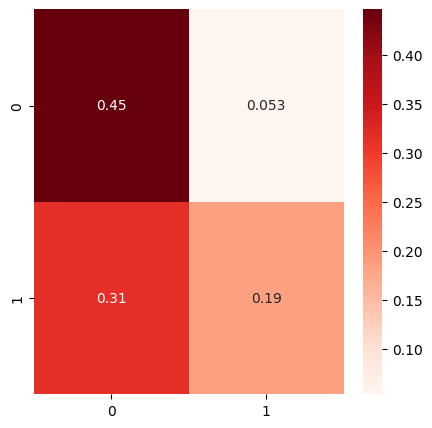

In [104]:
report(y_test, rfc_best.predict(x_test))

### 2. XGBRFClassifier

In [105]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [106]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-18 17:23:53,408] A new study created in memory with name: no-name-6f8090bb-6fd7-4c63-9854-7d720d1eadea


[17:23:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:53,854] Trial 0 finished with value: 0.3932203389830509 and parameters: {'max_depth': 6, 'n_estimators': 500}. Best is trial 0 with value: 0.3932203389830509.


[17:23:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:54,424] Trial 1 finished with value: 0.4401294498381877 and parameters: {'max_depth': 5, 'n_estimators': 800}. Best is trial 1 with value: 0.4401294498381877.


[17:23:54] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:54,915] Trial 2 finished with value: 0.43506493506493504 and parameters: {'max_depth': 5, 'n_estimators': 700}. Best is trial 1 with value: 0.4401294498381877.


[17:23:54] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:55,092] Trial 3 finished with value: 0.4645161290322581 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 3 with value: 0.4645161290322581.


[17:23:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:55,584] Trial 4 finished with value: 0.43506493506493504 and parameters: {'max_depth': 5, 'n_estimators': 700}. Best is trial 3 with value: 0.4645161290322581.


[17:23:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:55,803] Trial 5 finished with value: 0.4451612903225806 and parameters: {'max_depth': 5, 'n_estimators': 300}. Best is trial 3 with value: 0.4645161290322581.


[17:23:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:55,948] Trial 6 finished with value: 0.4 and parameters: {'max_depth': 8, 'n_estimators': 100}. Best is trial 3 with value: 0.4645161290322581.


[17:23:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:56,739] Trial 7 finished with value: 0.3932203389830509 and parameters: {'max_depth': 6, 'n_estimators': 900}. Best is trial 3 with value: 0.4645161290322581.


[17:23:56] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:57,150] Trial 8 finished with value: 0.4039735099337748 and parameters: {'max_depth': 7, 'n_estimators': 300}. Best is trial 3 with value: 0.4645161290322581.


[17:23:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:57,219] Trial 9 finished with value: 0.4645161290322581 and parameters: {'max_depth': 4, 'n_estimators': 100}. Best is trial 3 with value: 0.4645161290322581.


[17:23:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:57,967] Trial 10 finished with value: 0.4180064308681672 and parameters: {'max_depth': 10, 'n_estimators': 400}. Best is trial 3 with value: 0.4645161290322581.


[17:23:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:58,029] Trial 11 finished with value: 0.48734177215189867 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 11 with value: 0.48734177215189867.
[I 2024-11-18 17:23:58,133] Trial 12 finished with value: 0.4630225080385852 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 11 with value: 0.48734177215189867.


[17:23:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[17:23:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:58,364] Trial 13 finished with value: 0.4645161290322581 and parameters: {'max_depth': 3, 'n_estimators': 500}. Best is trial 11 with value: 0.48734177215189867.


[17:23:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:58,513] Trial 14 finished with value: 0.4645161290322581 and parameters: {'max_depth': 3, 'n_estimators': 300}. Best is trial 11 with value: 0.48734177215189867.


[17:23:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:58,862] Trial 15 finished with value: 0.39455782312925175 and parameters: {'max_depth': 4, 'n_estimators': 600}. Best is trial 11 with value: 0.48734177215189867.


[17:23:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:59,044] Trial 16 finished with value: 0.4183006535947712 and parameters: {'max_depth': 9, 'n_estimators': 100}. Best is trial 11 with value: 0.48734177215189867.


[17:23:59] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:23:59,608] Trial 17 finished with value: 0.3680555555555556 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 11 with value: 0.48734177215189867.


[17:23:59] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:24:00,061] Trial 18 finished with value: 0.4 and parameters: {'max_depth': 7, 'n_estimators': 400}. Best is trial 11 with value: 0.48734177215189867.
[I 2024-11-18 17:24:00,166] Trial 19 finished with value: 0.4630225080385852 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 11 with value: 0.48734177215189867.


[17:24:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[17:24:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:24:00,406] Trial 20 finished with value: 0.3835616438356165 and parameters: {'max_depth': 4, 'n_estimators': 400}. Best is trial 11 with value: 0.48734177215189867.


[17:24:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:24:00,482] Trial 21 finished with value: 0.4645161290322581 and parameters: {'max_depth': 4, 'n_estimators': 100}. Best is trial 11 with value: 0.48734177215189867.
[I 2024-11-18 17:24:00,587] Trial 22 finished with value: 0.4630225080385852 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 11 with value: 0.48734177215189867.


[17:24:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[17:24:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:24:00,664] Trial 23 finished with value: 0.4645161290322581 and parameters: {'max_depth': 4, 'n_estimators': 100}. Best is trial 11 with value: 0.48734177215189867.


[17:24:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:24:00,770] Trial 24 finished with value: 0.4630225080385852 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 11 with value: 0.48734177215189867.


[17:24:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:24:00,956] Trial 25 finished with value: 0.4 and parameters: {'max_depth': 4, 'n_estimators': 300}. Best is trial 11 with value: 0.48734177215189867.


[17:24:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:24:01,496] Trial 26 finished with value: 0.3932203389830509 and parameters: {'max_depth': 6, 'n_estimators': 600}. Best is trial 11 with value: 0.48734177215189867.
[I 2024-11-18 17:24:01,600] Trial 27 finished with value: 0.4630225080385852 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 11 with value: 0.48734177215189867.


[17:24:01] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[17:24:01] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:24:01,692] Trial 28 finished with value: 0.46202531645569617 and parameters: {'max_depth': 5, 'n_estimators': 100}. Best is trial 11 with value: 0.48734177215189867.


[17:24:01] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-18 17:24:01,986] Trial 29 finished with value: 0.3890784982935153 and parameters: {'max_depth': 4, 'n_estimators': 500}. Best is trial 11 with value: 0.48734177215189867.


In [107]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 100}
Best f1 score: 0.48734177215189867


In [108]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train, y_train)

[17:24:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=3, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [109]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_rfc_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

[17:24:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[17:24:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[17:24:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[17:24:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[17:24:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



{'fit_time': array([0.04054403, 0.04084778, 0.04196167, 0.04260421, 0.040488  ]),
 'score_time': array([0.01396513, 0.01138043, 0.01124549, 0.01119542, 0.01251745]),
 'test_accuracy': array([0.80335731, 0.81534772, 0.81971154, 0.80528846, 0.79326923]),
 'test_precision_macro': array([0.77631097, 0.79011032, 0.79623678, 0.77783613, 0.76552577]),
 'test_recall_macro': array([0.77631097, 0.78900199, 0.79044118, 0.77889812, 0.75460656]),
 'test_f1_macro': array([0.77631097, 0.78954992, 0.79317888, 0.77836099, 0.75944056]),
 'test_roc_auc': array([0.85644756, 0.87155903, 0.89795168, 0.8623962 , 0.8563332 ])}

In [110]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

         0.0       0.58      0.89      0.70       216
         1.0       0.77      0.36      0.49       216

    accuracy                           0.62       432
   macro avg       0.68      0.62      0.60       432
weighted avg       0.68      0.62      0.60       432

F2-score:  0.3993775933609958


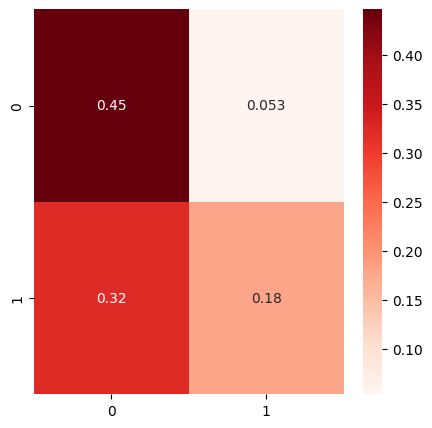

In [111]:
report(y_test, xgb_rfc_best.predict(x_test))

## Бустинги

### Catboost

In [112]:
import catboost

In [113]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [114]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-18 17:24:02,760] A new study created in memory with name: no-name-d9edc488-a3c9-4346-b5d7-1290f10ad791
[I 2024-11-18 17:24:03,327] Trial 0 finished with value: 0.06222222222222222 and parameters: {'learning_rate': 0.0027357248788384644, 'depth': 2, 'subsample': 0.5864923390573307, 'colsample_bylevel': 0.2531008548874604, 'min_data_in_leaf': 34, 'random_strength': 1.852753140600568}. Best is trial 0 with value: 0.06222222222222222.
[I 2024-11-18 17:24:04,057] Trial 1 finished with value: 0.2943396226415094 and parameters: {'learning_rate': 0.001192075836906055, 'depth': 3, 'subsample': 0.19163791520921897, 'colsample_bylevel': 0.9672164923062716, 'min_data_in_leaf': 65, 'random_strength': 0.8062626540917872}. Best is trial 1 with value: 0.2943396226415094.
[I 2024-11-18 17:24:04,642] Trial 2 finished with value: 0.10256410256410256 and parameters: {'learning_rate': 0.008060233156186194, 'depth': 1, 'subsample': 0.8128216217434219, 'colsample_bylevel': 0.44129224211060236, 'mi

In [115]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.05334423681740472, 'depth': 9, 'subsample': 0.714779907422747, 'colsample_bylevel': 0.48575836000488676, 'min_data_in_leaf': 74, 'random_strength': 0.5105379164631749}
Best f1 score: 0.46153846153846156


In [116]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train, y_train)

0:	learn: 0.6865487	total: 625us	remaining: 625ms
1:	learn: 0.6806508	total: 1.41ms	remaining: 703ms
2:	learn: 0.6753776	total: 1.97ms	remaining: 654ms
3:	learn: 0.6706621	total: 2.5ms	remaining: 623ms
4:	learn: 0.6468895	total: 3.16ms	remaining: 629ms
5:	learn: 0.6432876	total: 3.69ms	remaining: 611ms
6:	learn: 0.6226917	total: 4.3ms	remaining: 611ms
7:	learn: 0.6199343	total: 4.83ms	remaining: 598ms
8:	learn: 0.6174748	total: 5.34ms	remaining: 588ms
9:	learn: 0.6152777	total: 5.84ms	remaining: 579ms
10:	learn: 0.6133138	total: 6.37ms	remaining: 572ms
11:	learn: 0.6115519	total: 6.87ms	remaining: 565ms
12:	learn: 0.6099826	total: 7.37ms	remaining: 559ms
13:	learn: 0.6085812	total: 7.86ms	remaining: 554ms
14:	learn: 0.5932324	total: 8.48ms	remaining: 557ms
15:	learn: 0.5921485	total: 9.04ms	remaining: 556ms
16:	learn: 0.5787006	total: 9.69ms	remaining: 560ms
17:	learn: 0.5570691	total: 10.8ms	remaining: 592ms
18:	learn: 0.5450443	total: 11.6ms	remaining: 598ms
19:	learn: 0.5301566	tota

In [117]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6865361	total: 569us	remaining: 569ms
1:	learn: 0.6806291	total: 1.22ms	remaining: 607ms
2:	learn: 0.6550072	total: 1.84ms	remaining: 611ms
3:	learn: 0.6504564	total: 2.3ms	remaining: 573ms
4:	learn: 0.6463848	total: 2.75ms	remaining: 547ms
5:	learn: 0.6427490	total: 3.22ms	remaining: 533ms
6:	learn: 0.6394991	total: 3.66ms	remaining: 520ms
7:	learn: 0.6189554	total: 4.22ms	remaining: 523ms
8:	learn: 0.6164736	total: 4.66ms	remaining: 513ms
9:	learn: 0.6142642	total: 5.09ms	remaining: 504ms
10:	learn: 0.6122807	total: 5.52ms	remaining: 496ms
11:	learn: 0.5950995	total: 6.05ms	remaining: 498ms
12:	learn: 0.5936007	total: 6.5ms	remaining: 493ms
13:	learn: 0.5701093	total: 7.29ms	remaining: 514ms
14:	learn: 0.5571964	total: 7.88ms	remaining: 518ms
15:	learn: 0.5463981	total: 8.45ms	remaining: 520ms
16:	learn: 0.5304736	total: 9.21ms	remaining: 532ms
17:	learn: 0.5209457	total: 9.83ms	remaining: 536ms
18:	learn: 0.5080540	total: 10.5ms	remaining: 542ms
19:	learn: 0.5076744	tota

{'fit_time': array([0.58327293, 0.59172869, 0.59252048, 0.61123204, 0.60937929]),
 'score_time': array([0.00862741, 0.00835204, 0.00829482, 0.01101851, 0.00850725]),
 'test_accuracy': array([0.80335731, 0.81294964, 0.81490385, 0.80048077, 0.79807692]),
 'test_precision_macro': array([0.77683413, 0.78658444, 0.78986424, 0.7734375 , 0.77174727]),
 'test_recall_macro': array([0.77251675, 0.79670819, 0.7887605 , 0.76571767, 0.75816528]),
 'test_f1_macro': array([0.77457676, 0.79104995, 0.78930613, 0.76927035, 0.76403857]),
 'test_roc_auc': array([0.84297153, 0.86484718, 0.89329044, 0.87098985, 0.85523922])}

In [118]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

         0.0       0.56      0.89      0.69       216
         1.0       0.73      0.29      0.42       216

    accuracy                           0.59       432
   macro avg       0.65      0.59      0.55       432
weighted avg       0.65      0.59      0.55       432

F2-score:  0.3315789473684211


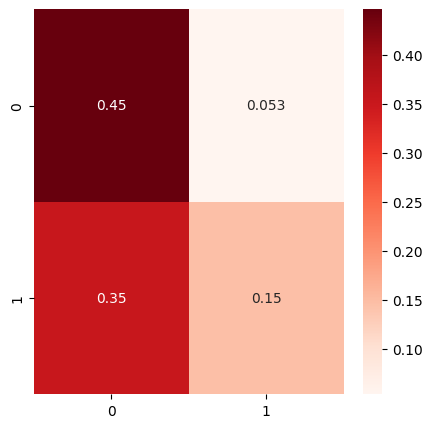

In [119]:
report(y_test, cb_best.predict(x_test))

### XGBoost

In [120]:
model = XGBClassifier()

In [121]:
model.fit(
    x_train,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [122]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [123]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-18 17:24:31,263] A new study created in memory with name: no-name-1ba1a580-b0eb-42cb-9c0c-f4da1b78e5ca


[17:24:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:32,585] Trial 0 finished with value: 0.35932203389830514 and parameters: {'learning_rate': 0.010766569659239274, 'max_depth': 296, 'n_estimators': 900, 'subsample': 0.36084611142043055, 'colsample_bylevel': 0.5575016515782418, 'gamma': 1.1852065834615597}. Best is trial 0 with value: 0.35932203389830514.


[17:24:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:33,171] Trial 1 finished with value: 0.3745819397993311 and parameters: {'learning_rate': 0.005503123678375049, 'max_depth': 157, 'n_estimators': 300, 'subsample': 0.6919726858309396, 'colsample_bylevel': 0.1893780422350123, 'gamma': 0.7724355865046627}. Best is trial 1 with value: 0.3745819397993311.


[17:24:33] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:34,685] Trial 2 finished with value: 0.35172413793103446 and parameters: {'learning_rate': 0.006082752057710572, 'max_depth': 467, 'n_estimators': 700, 'subsample': 0.6596780638741117, 'colsample_bylevel': 0.6718598147141358, 'gamma': 1.2614273312693203}. Best is trial 1 with value: 0.3745819397993311.


[17:24:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:36,458] Trial 3 finished with value: 0.36486486486486486 and parameters: {'learning_rate': 0.0014310803486375899, 'max_depth': 107, 'n_estimators': 900, 'subsample': 0.7632507359295545, 'colsample_bylevel': 0.4401215555193906, 'gamma': 0.9464245853594082}. Best is trial 1 with value: 0.3745819397993311.


[17:24:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:41,605] Trial 4 finished with value: 0.3754266211604096 and parameters: {'learning_rate': 0.01927544408192092, 'max_depth': 443, 'n_estimators': 800, 'subsample': 0.997278670347445, 'colsample_bylevel': 0.24105789108559722, 'gamma': 0.8735746967135664}. Best is trial 4 with value: 0.3754266211604096.


[17:24:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:42,082] Trial 5 finished with value: 0.3960396039603961 and parameters: {'learning_rate': 0.010330695819126344, 'max_depth': 236, 'n_estimators': 200, 'subsample': 0.7016931283621031, 'colsample_bylevel': 0.5343975546214732, 'gamma': 0.2928892488286192}. Best is trial 5 with value: 0.3960396039603961.


[17:24:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:43,237] Trial 6 finished with value: 0.37037037037037035 and parameters: {'learning_rate': 0.007243214394302354, 'max_depth': 293, 'n_estimators': 500, 'subsample': 0.6206576964596277, 'colsample_bylevel': 0.3944679376510193, 'gamma': 0.38678277326917654}. Best is trial 5 with value: 0.3960396039603961.


[17:24:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:43,787] Trial 7 finished with value: 0.4220779220779221 and parameters: {'learning_rate': 0.019517543167711992, 'max_depth': 356, 'n_estimators': 400, 'subsample': 0.27843293548407466, 'colsample_bylevel': 0.11762267300352279, 'gamma': 0.3218529663724208}. Best is trial 7 with value: 0.4220779220779221.


[17:24:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:44,848] Trial 8 finished with value: 0.43506493506493504 and parameters: {'learning_rate': 0.0016674643942674843, 'max_depth': 179, 'n_estimators': 800, 'subsample': 0.3865238885879945, 'colsample_bylevel': 0.5328258851947932, 'gamma': 2.2736743399777626}. Best is trial 8 with value: 0.43506493506493504.


[17:24:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:45,820] Trial 9 finished with value: 0.4281150159744409 and parameters: {'learning_rate': 0.0032042578560982486, 'max_depth': 251, 'n_estimators': 700, 'subsample': 0.3172956020149473, 'colsample_bylevel': 0.11565968454164004, 'gamma': 0.46104847439818397}. Best is trial 8 with value: 0.43506493506493504.


[17:24:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:46,365] Trial 10 finished with value: 0.3812709030100334 and parameters: {'learning_rate': 0.0670256362337882, 'max_depth': 186, 'n_estimators': 1000, 'subsample': 0.05320870446811499, 'colsample_bylevel': 0.990682606108898, 'gamma': 2.386526569030294}. Best is trial 8 with value: 0.43506493506493504.


[17:24:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:47,213] Trial 11 finished with value: 0.4437299035369775 and parameters: {'learning_rate': 0.0013983773063669352, 'max_depth': 226, 'n_estimators': 600, 'subsample': 0.3783999852880817, 'colsample_bylevel': 0.7558289688817315, 'gamma': 2.1039912796049394}. Best is trial 11 with value: 0.4437299035369775.


[17:24:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:48,132] Trial 12 finished with value: 0.46056782334384855 and parameters: {'learning_rate': 0.001098403414147974, 'max_depth': 189, 'n_estimators': 600, 'subsample': 0.4472416583319836, 'colsample_bylevel': 0.9098307371713517, 'gamma': 2.056962686895236}. Best is trial 12 with value: 0.46056782334384855.


[17:24:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:49,123] Trial 13 finished with value: 0.4220779220779221 and parameters: {'learning_rate': 0.0010998838471119139, 'max_depth': 350, 'n_estimators': 600, 'subsample': 0.5122856507999075, 'colsample_bylevel': 0.8548654087258429, 'gamma': 1.9064881408293703}. Best is trial 12 with value: 0.46056782334384855.


[17:24:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:49,547] Trial 14 finished with value: 0.39590443686006827 and parameters: {'learning_rate': 0.0022371223086404693, 'max_depth': 100, 'n_estimators': 500, 'subsample': 0.13971373192727887, 'colsample_bylevel': 0.7797225238446003, 'gamma': 2.8455085653074286}. Best is trial 12 with value: 0.46056782334384855.


[17:24:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:50,502] Trial 15 finished with value: 0.43225806451612897 and parameters: {'learning_rate': 0.0010302934424119717, 'max_depth': 233, 'n_estimators': 600, 'subsample': 0.48659081539117993, 'colsample_bylevel': 0.9545330077428199, 'gamma': 1.8896685064357424}. Best is trial 12 with value: 0.46056782334384855.
[I 2024-11-18 17:24:50,629] Trial 16 finished with value: 0.4013377926421405 and parameters: {'learning_rate': 0.0031670713007975588, 'max_depth': 366, 'n_estimators': 100, 'subsample': 0.22922305824548403, 'colsample_bylevel': 0.7357496682520716, 'gamma': 1.7324542470740683}. Best is trial 12 with value: 0.46056782334384855.


[17:24:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[17:24:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:51,436] Trial 17 finished with value: 0.4131147540983607 and parameters: {'learning_rate': 0.08180622073409213, 'max_depth': 159, 'n_estimators': 400, 'subsample': 0.44798481642113697, 'colsample_bylevel': 0.828892531631928, 'gamma': 2.342721429118582}. Best is trial 12 with value: 0.46056782334384855.


[17:24:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:53,406] Trial 18 finished with value: 0.4716981132075472 and parameters: {'learning_rate': 0.002958335349517184, 'max_depth': 215, 'n_estimators': 700, 'subsample': 0.8494194919981146, 'colsample_bylevel': 0.6593921172646813, 'gamma': 2.849597753627299}. Best is trial 18 with value: 0.4716981132075472.


[17:24:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:55,470] Trial 19 finished with value: 0.4827586206896551 and parameters: {'learning_rate': 0.0033304633837849245, 'max_depth': 201, 'n_estimators': 700, 'subsample': 0.8764057338588027, 'colsample_bylevel': 0.6409474840167589, 'gamma': 2.9121395153428944}. Best is trial 19 with value: 0.4827586206896551.


[17:24:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:24:57,935] Trial 20 finished with value: 0.4842767295597485 and parameters: {'learning_rate': 0.0032793136085925256, 'max_depth': 273, 'n_estimators': 800, 'subsample': 0.9066858073458581, 'colsample_bylevel': 0.6438936131466068, 'gamma': 2.9921057331648084}. Best is trial 20 with value: 0.4842767295597485.


[17:24:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:00,028] Trial 21 finished with value: 0.47468354430379733 and parameters: {'learning_rate': 0.003132109637413659, 'max_depth': 270, 'n_estimators': 800, 'subsample': 0.9028499622566813, 'colsample_bylevel': 0.6430557393504918, 'gamma': 2.9399422360907397}. Best is trial 20 with value: 0.4842767295597485.


[17:25:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:03,096] Trial 22 finished with value: 0.5525525525525525 and parameters: {'learning_rate': 0.0045742161322504865, 'max_depth': 274, 'n_estimators': 1000, 'subsample': 0.9987994335085848, 'colsample_bylevel': 0.6178652946815226, 'gamma': 2.9746687811389267}. Best is trial 22 with value: 0.5525525525525525.


[17:25:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:06,441] Trial 23 finished with value: 0.467948717948718 and parameters: {'learning_rate': 0.004819703002879697, 'max_depth': 321, 'n_estimators': 1000, 'subsample': 0.9989511307467399, 'colsample_bylevel': 0.39754214829954376, 'gamma': 2.614913353725658}. Best is trial 22 with value: 0.5525525525525525.


[17:25:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:09,864] Trial 24 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.01513790215191623, 'max_depth': 272, 'n_estimators': 900, 'subsample': 0.8791111900394888, 'colsample_bylevel': 0.617205275722294, 'gamma': 2.6619674258087787}. Best is trial 22 with value: 0.5525525525525525.


[17:25:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:12,554] Trial 25 finished with value: 0.3448275862068966 and parameters: {'learning_rate': 0.004321441144623844, 'max_depth': 398, 'n_estimators': 1000, 'subsample': 0.7797604117588237, 'colsample_bylevel': 0.4277484514742924, 'gamma': 2.6126694006305877}. Best is trial 22 with value: 0.5525525525525525.


[17:25:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:14,790] Trial 26 finished with value: 0.5092024539877301 and parameters: {'learning_rate': 0.0021164162873050425, 'max_depth': 323, 'n_estimators': 900, 'subsample': 0.9191786803015567, 'colsample_bylevel': 0.3345163698877004, 'gamma': 2.9969704417640544}. Best is trial 22 with value: 0.5525525525525525.


[17:25:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:17,061] Trial 27 finished with value: 0.5 and parameters: {'learning_rate': 0.002061325822117208, 'max_depth': 328, 'n_estimators': 900, 'subsample': 0.9382007812448172, 'colsample_bylevel': 0.3320912009859833, 'gamma': 2.5357539760618053}. Best is trial 22 with value: 0.5525525525525525.


[17:25:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:18,691] Trial 28 finished with value: 0.41558441558441556 and parameters: {'learning_rate': 0.0019892969827604843, 'max_depth': 408, 'n_estimators': 900, 'subsample': 0.5880660786442106, 'colsample_bylevel': 0.3121285274708687, 'gamma': 2.4803259291027504}. Best is trial 22 with value: 0.5525525525525525.


[17:25:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:22,819] Trial 29 finished with value: 0.37837837837837834 and parameters: {'learning_rate': 0.007919971864011948, 'max_depth': 315, 'n_estimators': 1000, 'subsample': 0.9476107375976099, 'colsample_bylevel': 0.3086915925498915, 'gamma': 1.5068410151676679}. Best is trial 22 with value: 0.5525525525525525.


In [124]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.0045742161322504865, 'max_depth': 274, 'n_estimators': 1000, 'subsample': 0.9987994335085848, 'colsample_bylevel': 0.6178652946815226, 'gamma': 2.9746687811389267}
Best f1 score: 0.5525525525525525


In [125]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train, y_train)

[17:25:22] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6178652946815226, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.9746687811389267, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0045742161322504865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=274, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [126]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

[17:25:25] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[17:25:28] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[17:25:31] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[17:25:33] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[17:25:36] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([2.61370564, 2.52409005, 2.52978635, 2.42778325, 2.2831223 ]),
 'score_time': array([0.01437211, 0.01457787, 0.01355004, 0.01393056, 0.01394701]),
 'test_accuracy': array([0.79616307, 0.8057554 , 0.81971154, 0.79326923, 0.79807692]),
 'test_precision_macro': array([0.7689761 , 0.7786356 , 0.79623678, 0.76422829, 0.77537311]),
 'test_recall_macro': array([0.76148734, 0.78567877, 0.79044118, 0.76422829, 0.74854356]),
 'test_f1_macro': array([0.7649302 , 0.78186574, 0.79317888, 0.76422829, 0.75872735]),
 'test_roc_auc': array([0.84921237, 0.86954417, 0.8967437 , 0.86480822, 0.85492289])}

In [127]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

         0.0       0.61      0.88      0.72       216
         1.0       0.79      0.43      0.55       216

    accuracy                           0.66       432
   macro avg       0.70      0.66      0.64       432
weighted avg       0.70      0.66      0.64       432

F2-score:  0.4689092762487258


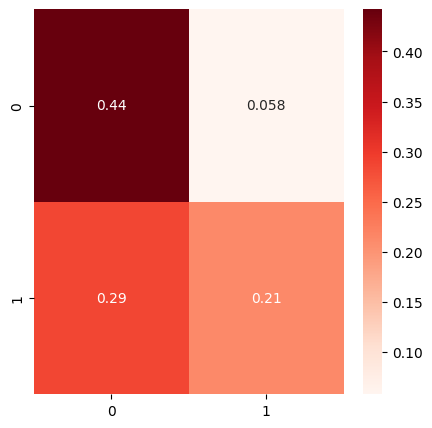

In [128]:
report(y_test, xgb_best.predict(x_test))

### LightGBM

In [129]:
model = LGBMClassifier()

In [130]:
model.fit(
    x_train,
    y_train,
    )

LGBMClassifier()

In [131]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [132]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-18 17:25:38,642] A new study created in memory with name: no-name-b37915e7-639a-4014-b9b8-2b27386cf7fa


[17:25:38] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:38,906] Trial 0 finished with value: 0.4220779220779221 and parameters: {'learning_rate': 0.0057255122862623995, 'max_depth': 419, 'n_estimators': 200, 'subsample': 0.3767181339297765, 'colsample_bylevel': 0.4920598153722039, 'gamma': 1.7488464786353497}. Best is trial 0 with value: 0.4220779220779221.


[17:25:38] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:39,651] Trial 1 finished with value: 0.4401294498381877 and parameters: {'learning_rate': 0.005989413786675491, 'max_depth': 490, 'n_estimators': 500, 'subsample': 0.40188538618748887, 'colsample_bylevel': 0.561539584799083, 'gamma': 2.3297198356764386}. Best is trial 1 with value: 0.4401294498381877.


[17:25:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:41,510] Trial 2 finished with value: 0.35374149659863946 and parameters: {'learning_rate': 0.006742614776256636, 'max_depth': 265, 'n_estimators': 800, 'subsample': 0.677521618252601, 'colsample_bylevel': 0.4391441922682053, 'gamma': 1.8496356586824498}. Best is trial 1 with value: 0.4401294498381877.


[17:25:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:42,027] Trial 3 finished with value: 0.45341614906832295 and parameters: {'learning_rate': 0.038556241075112706, 'max_depth': 172, 'n_estimators': 600, 'subsample': 0.15602008706717913, 'colsample_bylevel': 0.3981221540391169, 'gamma': 0.5407229245379654}. Best is trial 3 with value: 0.45341614906832295.


[17:25:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:42,183] Trial 4 finished with value: 0.40259740259740256 and parameters: {'learning_rate': 0.004575536559882155, 'max_depth': 390, 'n_estimators': 100, 'subsample': 0.5541484398585264, 'colsample_bylevel': 0.8736373842049878, 'gamma': 0.8618346746226324}. Best is trial 3 with value: 0.45341614906832295.


[17:25:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:42,608] Trial 5 finished with value: 0.38666666666666666 and parameters: {'learning_rate': 0.004210101673900491, 'max_depth': 172, 'n_estimators': 200, 'subsample': 0.9210679152112676, 'colsample_bylevel': 0.8320917630916047, 'gamma': 1.272615394081808}. Best is trial 3 with value: 0.45341614906832295.


[17:25:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:43,259] Trial 6 finished with value: 0.4052287581699347 and parameters: {'learning_rate': 0.03141219501240786, 'max_depth': 130, 'n_estimators': 400, 'subsample': 0.4219927776303017, 'colsample_bylevel': 0.14891698156684285, 'gamma': 0.7348898159905648}. Best is trial 3 with value: 0.45341614906832295.


[17:25:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:44,037] Trial 7 finished with value: 0.43729903536977494 and parameters: {'learning_rate': 0.002383044044541156, 'max_depth': 292, 'n_estimators': 900, 'subsample': 0.18139757425502223, 'colsample_bylevel': 0.25960910935433595, 'gamma': 0.7009032194621103}. Best is trial 3 with value: 0.45341614906832295.


[17:25:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:46,575] Trial 8 finished with value: 0.38666666666666666 and parameters: {'learning_rate': 0.0031273469325091446, 'max_depth': 256, 'n_estimators': 900, 'subsample': 0.967134778614632, 'colsample_bylevel': 0.30570093447657604, 'gamma': 0.21680012119598208}. Best is trial 3 with value: 0.45341614906832295.


[17:25:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:46,882] Trial 9 finished with value: 0.37748344370860926 and parameters: {'learning_rate': 0.07594970761803574, 'max_depth': 105, 'n_estimators': 200, 'subsample': 0.3689796314640671, 'colsample_bylevel': 0.5480532503944129, 'gamma': 2.2692074605796964}. Best is trial 3 with value: 0.45341614906832295.


[17:25:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:47,259] Trial 10 finished with value: 0.36860068259385664 and parameters: {'learning_rate': 0.019680511638291993, 'max_depth': 202, 'n_estimators': 700, 'subsample': 0.052803717562105335, 'colsample_bylevel': 0.056508498417089326, 'gamma': 0.12342041665741221}. Best is trial 3 with value: 0.45341614906832295.


[17:25:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:47,703] Trial 11 finished with value: 0.4054054054054055 and parameters: {'learning_rate': 0.0013138732370583924, 'max_depth': 497, 'n_estimators': 500, 'subsample': 0.19911753690816603, 'colsample_bylevel': 0.6419762371123896, 'gamma': 2.938495380608516}. Best is trial 3 with value: 0.45341614906832295.


[17:25:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:48,398] Trial 12 finished with value: 0.42345276872964166 and parameters: {'learning_rate': 0.015041101616758482, 'max_depth': 384, 'n_estimators': 600, 'subsample': 0.24130462925668789, 'colsample_bylevel': 0.6791866062329478, 'gamma': 2.476749395780223}. Best is trial 3 with value: 0.45341614906832295.


[17:25:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:49,293] Trial 13 finished with value: 0.37623762376237624 and parameters: {'learning_rate': 0.05720479457452476, 'max_depth': 483, 'n_estimators': 400, 'subsample': 0.6172133898447503, 'colsample_bylevel': 0.34812288816879644, 'gamma': 1.3908024328652122}. Best is trial 3 with value: 0.45341614906832295.


[17:25:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:50,870] Trial 14 finished with value: 0.35494880546075086 and parameters: {'learning_rate': 0.01124714324338887, 'max_depth': 347, 'n_estimators': 600, 'subsample': 0.7367672788262161, 'colsample_bylevel': 0.7099777932137472, 'gamma': 2.203313586056889}. Best is trial 3 with value: 0.45341614906832295.


[17:25:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:51,144] Trial 15 finished with value: 0.4939024390243903 and parameters: {'learning_rate': 0.0346781707541596, 'max_depth': 208, 'n_estimators': 400, 'subsample': 0.08022610972168324, 'colsample_bylevel': 0.41159826950022393, 'gamma': 2.9776988256101697}. Best is trial 15 with value: 0.4939024390243903.


[17:25:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:51,375] Trial 16 finished with value: 0.37710437710437705 and parameters: {'learning_rate': 0.037298299970111824, 'max_depth': 212, 'n_estimators': 400, 'subsample': 0.05433555178789545, 'colsample_bylevel': 0.40309555999867813, 'gamma': 2.9215364140268516}. Best is trial 15 with value: 0.4939024390243903.


[17:25:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:52,253] Trial 17 finished with value: 0.3787375415282392 and parameters: {'learning_rate': 0.0299064331626422, 'max_depth': 154, 'n_estimators': 700, 'subsample': 0.2767015728439539, 'colsample_bylevel': 0.2779616869853129, 'gamma': 1.0274376959417149}. Best is trial 15 with value: 0.4939024390243903.


[17:25:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:52,537] Trial 18 finished with value: 0.4077669902912622 and parameters: {'learning_rate': 0.08930648071481659, 'max_depth': 217, 'n_estimators': 300, 'subsample': 0.14242539621484906, 'colsample_bylevel': 0.9912707135088208, 'gamma': 0.5211654190891155}. Best is trial 15 with value: 0.4939024390243903.


[17:25:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:53,821] Trial 19 finished with value: 0.4 and parameters: {'learning_rate': 0.05061910632540261, 'max_depth': 322, 'n_estimators': 1000, 'subsample': 0.2905461730688527, 'colsample_bylevel': 0.16959456571253123, 'gamma': 2.66674961586188}. Best is trial 15 with value: 0.4939024390243903.


[17:25:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:54,277] Trial 20 finished with value: 0.5015105740181268 and parameters: {'learning_rate': 0.020604495714115968, 'max_depth': 242, 'n_estimators': 600, 'subsample': 0.10981074692363654, 'colsample_bylevel': 0.40955822588527296, 'gamma': 1.975093447732018}. Best is trial 20 with value: 0.5015105740181268.


[17:25:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:54,828] Trial 21 finished with value: 0.4487179487179487 and parameters: {'learning_rate': 0.020219400168625515, 'max_depth': 250, 'n_estimators': 700, 'subsample': 0.12042600441737641, 'colsample_bylevel': 0.4009556816437294, 'gamma': 1.6692347679164639}. Best is trial 20 with value: 0.5015105740181268.


[17:25:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:55,199] Trial 22 finished with value: 0.5250737463126844 and parameters: {'learning_rate': 0.024064513169065906, 'max_depth': 181, 'n_estimators': 500, 'subsample': 0.10076471500570242, 'colsample_bylevel': 0.4444269729728486, 'gamma': 1.9997610991769197}. Best is trial 22 with value: 0.5250737463126844.


[17:25:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:55,528] Trial 23 finished with value: 0.5454545454545455 and parameters: {'learning_rate': 0.019625550187742615, 'max_depth': 231, 'n_estimators': 500, 'subsample': 0.0785821260099806, 'colsample_bylevel': 0.4906326693847143, 'gamma': 2.0038912525577803}. Best is trial 23 with value: 0.5454545454545455.


[17:25:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:56,184] Trial 24 finished with value: 0.4380952380952381 and parameters: {'learning_rate': 0.009730432156554772, 'max_depth': 292, 'n_estimators': 500, 'subsample': 0.29670026614236394, 'colsample_bylevel': 0.6036600852363793, 'gamma': 2.0167307798041265}. Best is trial 23 with value: 0.5454545454545455.


[17:25:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:56,770] Trial 25 finished with value: 0.36666666666666664 and parameters: {'learning_rate': 0.021504772119933145, 'max_depth': 235, 'n_estimators': 300, 'subsample': 0.5021396687203536, 'colsample_bylevel': 0.4998950871702571, 'gamma': 1.8661731473346035}. Best is trial 23 with value: 0.5454545454545455.


[17:25:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:59,206] Trial 26 finished with value: 0.37333333333333335 and parameters: {'learning_rate': 0.010818710679939251, 'max_depth': 182, 'n_estimators': 800, 'subsample': 0.8188045234199532, 'colsample_bylevel': 0.7459759023239306, 'gamma': 1.509499758991947}. Best is trial 23 with value: 0.5454545454545455.


[17:25:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:25:59,715] Trial 27 finished with value: 0.46875 and parameters: {'learning_rate': 0.013997486194647996, 'max_depth': 138, 'n_estimators': 500, 'subsample': 0.1914641725575155, 'colsample_bylevel': 0.2096744284723998, 'gamma': 2.009602827419277}. Best is trial 23 with value: 0.5454545454545455.


[17:25:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:26:00,177] Trial 28 finished with value: 0.4672897196261682 and parameters: {'learning_rate': 0.02358576259670596, 'max_depth': 273, 'n_estimators': 600, 'subsample': 0.11058420523007953, 'colsample_bylevel': 0.4972080389280805, 'gamma': 2.621476528062093}. Best is trial 23 with value: 0.5454545454545455.


[17:26:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-18 17:26:00,600] Trial 29 finished with value: 0.4220779220779221 and parameters: {'learning_rate': 0.008043914542654153, 'max_depth': 325, 'n_estimators': 300, 'subsample': 0.3367418586322576, 'colsample_bylevel': 0.4699324447913628, 'gamma': 2.0773121585842387}. Best is trial 23 with value: 0.5454545454545455.


In [133]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.019625550187742615, 'max_depth': 231, 'n_estimators': 500, 'subsample': 0.0785821260099806, 'colsample_bylevel': 0.4906326693847143, 'gamma': 2.0038912525577803}
Best f1 score: 0.5454545454545455


In [134]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.019625550187742615, max_depth=231,
               n_estimators=500, random_seed=42, subsample=0.0785821260099806)

In [135]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.25696659, 0.25915504, 0.25274611, 0.2508781 , 0.25064588]),
 'score_time': array([0.01591587, 0.01616001, 0.01525831, 0.01549053, 0.01529646]),
 'test_accuracy': array([0.77697842, 0.78417266, 0.80528846, 0.79567308, 0.78605769]),
 'test_precision_macro': array([0.74653099, 0.75550562, 0.77840692, 0.76817187, 0.75629371]),
 'test_recall_macro': array([0.75104668, 0.76776743, 0.78728992, 0.75831027, 0.75119283]),
 'test_f1_macro': array([0.74864702, 0.76054055, 0.78236916, 0.76273393, 0.75359223]),
 'test_roc_auc': array([0.82241731, 0.83830071, 0.87580095, 0.8537762 , 0.84331093])}

In [136]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

         0.0       0.54      0.88      0.67       216
         1.0       0.68      0.25      0.36       216

    accuracy                           0.56       432
   macro avg       0.61      0.56      0.52       432
weighted avg       0.61      0.56      0.52       432

F2-score:  0.28601694915254233


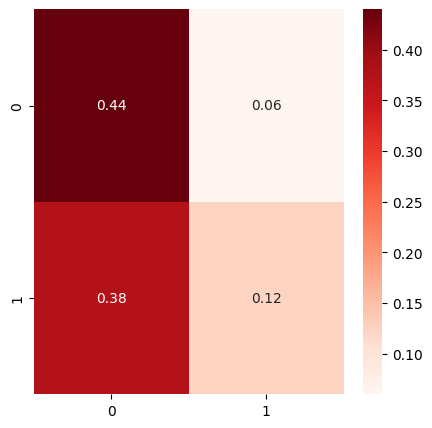

In [137]:
report(y_test, lgbm_best.predict(x_test))

# Результаты

In [138]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [139]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [140]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [141]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.81 +- 0.01 , 'AUC': 0.87 +- 0.02 ,'Precision': 0.78 +- 0.01 ,'Recall': 0.78 +- 0.01 ,'F1-score': 0.78 +- 0.01 ,'F2-score': 0.78 +- 0.01
'Accuracy': 0.81 +- 0.01 , 'AUC': 0.87 +- 0.02 ,'Precision': 0.78 +- 0.01 ,'Recall': 0.78 +- 0.01 ,'F1-score': 0.78 +- 0.01 ,'F2-score': 0.78 +- 0.01
'Accuracy': 0.8 +- 0.01 , 'AUC': 0.87 +- 0.02 ,'Precision': 0.78 +- 0.01 ,'Recall': 0.77 +- 0.02 ,'F1-score': 0.77 +- 0.01 ,'F2-score': 0.77 +- 0.01
'Accuracy': 0.79 +- 0.01 , 'AUC': 0.85 +- 0.02 ,'Precision': 0.76 +- 0.01 ,'Recall': 0.76 +- 0.01 ,'F1-score': 0.76 +- 0.01 ,'F2-score': 0.76 +- 0.01
'Accuracy': 0.81 +- 0.01 , 'AUC': 0.87 +- 0.02 ,'Precision': 0.78 +- 0.01 ,'Recall': 0.78 +- 0.01 ,'F1-score': 0.78 +- 0.01 ,'F2-score': 0.78 +- 0.01


In [142]:
for model in best_models:
  print(test_results(model, x_val, y_val))

{'Accuracy': 0.82, 'AUC': 0.79, 'Precision': 0.71, 'Recall': 0.71, 'F1-score': 0.71, 'F2-score': 0.71}
{'Accuracy': 0.82, 'AUC': 0.79, 'Precision': 0.72, 'Recall': 0.71, 'F1-score': 0.71, 'F2-score': 0.71}
{'Accuracy': 0.82, 'AUC': 0.79, 'Precision': 0.7, 'Recall': 0.74, 'F1-score': 0.72, 'F2-score': 0.73}
{'Accuracy': 0.8, 'AUC': 0.77, 'Precision': 0.7, 'Recall': 0.67, 'F1-score': 0.68, 'F2-score': 0.67}
{'Accuracy': 0.82, 'AUC': 0.79, 'Precision': 0.72, 'Recall': 0.7, 'F1-score': 0.71, 'F2-score': 0.7}


In [143]:
for model in best_models:
  print(test_results(model, x_test, y_test))

{'Accuracy': 0.63, 'AUC': 0.63, 'Precision': 0.78, 'Recall': 0.37, 'F1-score': 0.5, 'F2-score': 0.41}
{'Accuracy': 0.62, 'AUC': 0.62, 'Precision': 0.77, 'Recall': 0.36, 'F1-score': 0.49, 'F2-score': 0.4}
{'Accuracy': 0.66, 'AUC': 0.66, 'Precision': 0.79, 'Recall': 0.43, 'F1-score': 0.55, 'F2-score': 0.47}
{'Accuracy': 0.56, 'AUC': 0.56, 'Precision': 0.68, 'Recall': 0.25, 'F1-score': 0.36, 'F2-score': 0.29}
{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.73, 'Recall': 0.29, 'F1-score': 0.42, 'F2-score': 0.33}
